# Topic Modeling

El modelamiento de tópicos, es una herramienta estadística que busca encontrar los temas presentes en un conjunto de documentos (corpus), permitiendo organizar, buscar, indexar, explorar y comprender grandes colecciones de documentos.\\


En este sentido, los temas se pueden definir como **un patrón repetitivo de términos co-currentes en un corpus**. Por ejemplo, se tiene el siguiente tópico, representado por sus **cuatro palabras más probables**, ``salud``, ``médico``, ``paciente``, ``hospital``, estas palabras sugieren el siguiente nombre para el tema: **Atención médica**.




<img src='img/inferring_topic.png' width="800" height="800">




En los modelos convencionales de tópicos:
1. Las palabras dentro de un documento y los documentos son tratados como intercambiables, por tanto, trabajan bajo un modelo **bag-of-words**.
2. Cada documento es generado por una mezcla de $K$ tópicos, por ejemplo, para $K=3$ la mezcla de tópicos puede ser $\theta_{d}=[0.1, 0.2, 0.7]$, en este caso el tópico 3 tiene más propabilidad de haber generado el documento o puede interpretarse que hay más presencia de ese tópico en el documento.
3. Cada tópico es una distribución de probabilidad sobre un vocabulario $V$, por ejemplo, $\beta_{k}=[w_{1}^{k}, \ldots, w_{|V|}^{k}]
$, donde $w_{i}^{k}\geq 0$ y $\sum_{i=1}^{|V|}w_{i}^{k}=1$.
4 Los tópicos son interpretados por humanos a través de la lectura de las palabras más probables que lo componen.

<img src='img/topic_modeling.png'>

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import re
    
#Preprocesamiento
import spacy
from spacy.lang.es.stop_words import STOP_WORDS #importar set de stopwords
from nltk.stem import SnowballStemmer #importar stemmer
nlp = spacy.load('es_core_news_sm') #python -m spacy download es

#Bag-of-words
from sklearn.feature_extraction.text import CountVectorizer  

#Topic modeling
import gensim
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

#Elimina los warnings
import warnings
warnings.filterwarnings("ignore")

### Base de datos
La base de datos consiste de 5 conjuntos de noticias extraídas de la radio biobio. 
Cada conjunto de noticias contiene 200 documentos (noticias) y tiene asociado una categoría en {nacional, internacional, economía, sociedad, opinion}.

**Creditos**: 

- Pablo Badilla Torrealba 
- https://github.com/dccuchile/CC6205/tree/master/tutorials

In [2]:
df = pd.read_csv('news_biobio.csv', index_col=0)

In [227]:
pd.set_option('display.max_colwidth', 0)

In [3]:
def tokenizer(doc, sep=None, stopwords_remove =False, lemmatization=False, stemming = False, vocabulary=None):
    '''
    Por defecto divide la sentencia por el carácter espacio.
    Ej: 'Data Mining is the best course'->['Data',  'Mining', 'is', 'the', 'best', 'course']
    
    Input: 
    1. doc: str, documento.
    2. sep: str, carácter para dividir el documento en tokens, por defecto es el espacio.
    3. stopwords_remove: bool, si es True remueve los stopwords del documento.
    4. lemmatization: bool, si es True lleva las palabras a su lema.
    5. stemming: bool, si es True lleva las palabas a su raíz.
    6. vocabuary: list, si un vocabulario es dado filtra las palabras que no estan presentes en el.
    
    Output: 
    list, lista de tokens.
    
    Nota: aplicar stemming y lemmatization al mismo tiempo no es correcto.
    '''
    doc = re.sub(r'[^\w\s]','', doc) #elimina los símbolos de puntuación
    doc = re.sub(r'[a-zA-Z]+[0-9]+', '', doc) #elimina los caracteres que contienen letras y números
    doc = re.sub(r'[0-9]+', ' ', doc) #elimina los caracteres numéricos
   
    tokens = doc.split(sep) #tokenización
    tokens = [word.lower() for word in tokens] #pasar todas las palabras a minúsculas
    
    
    
    if stopwords_remove ==True: #remover stopwords y palabras con menos de tres caracteres
        tokens = [word for word in tokens if word not in STOP_WORDS and len(word)>2]
    
    if lemmatization==True:
        tokens = [nlp(word)[0].lemma_ for word in tokens]
        
    if stemming == True:
        stemmer = SnowballStemmer('spanish')
        tokens = [stemmer.stem(word) for word in tokens]
    
    if vocabulary is not None:
        tokens = [word for word in tokens if word in vocabulary]
    
    return tokens


## 1. Latent Dirichlet Allocation
 
Sean  $K$  tópicos, $\beta_{1:K}$ son distribuciones de probabilidad sobre un vocabulario fijo, dibujadas por una $Dirichlet(\eta)$. Para cada documento $d$ del corpus $D$ se asume que es dibujado por el siguiente proceso generativo:


1. Escoger la mezcla de tópicos $\theta_{d}$ de una distribución sobre un $(K− 1)-simplex$, tal como una $Dirichlet(\alpha)$.
2. Para cada palabra:
    - Escoger la asignación del tópico $z\sim Mult(\theta_{d})$
    - Escoger una palabra $w \sim Mult(\beta_{z})$


<img src='img/lda_graphical_model.png'>

In [50]:
#Extraer corpus del dataframe
titles, data, categories  = df.title, df.content, df.category


#Obtener bag-of-words del corpus
args = {"stopwords_remove": True}
tf_vectorizer = CountVectorizer(analyzer='word', tokenizer=lambda text: tokenizer(text, **args), 
                                    max_df = 0.8, min_df = 5, dtype=np.double)
#BOW del corpus
%time bow = tf_vectorizer.fit_transform(data)

#Extrae vocabulario
vocabulary = tf_vectorizer.get_feature_names()

#Corpus tokenizado utilizando el vocabulario postprocesado obtenido por Countvectorizer
data_tokenized = [tokenizer(doc, stopwords_remove=True, vocabulary=vocabulary) for doc in data]

#Creamos el diccionario a partir de los textos procesados en el formato que necesita LDA en gensim
dictionary = Dictionary(data_tokenized)

#Transformamos el corpus al formato que requiere la librería
#El corpus contiene una representacion numerica de los textos, un texto es representado por una lista de tuplas
#donde el primer elemento de la tupla es la id de la palabra y el segundo es su frecuencia de aparición en el texto.
corpus = [dictionary.doc2bow(text) for text in data_tokenized]

Wall time: 641 ms


In [31]:
#guardamos el diccionario y el corpus
dictionary.save('dictionary.dict')
MmCorpus.serialize('corpus.mm', corpus)

In [32]:
print('Tamaño del vocabulario', len(vocabulary))
print('Primer elemento del diccionario o bolsa de palabras:', dictionary[0])
print('Representación del corpus en el formato que requiere la librería: \n', corpus[0][0:10])

Tamaño del vocabulario 2876
Primer elemento del diccionario o bolsa de palabras: agua
Representación del corpus en el formato que requiere la librería: 
 [(0, 4), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [65]:
#entrenamos lda en el corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=12, alpha='auto', eta='auto', random_state=0) 

In [66]:
#guardamos el modelo
lda_model.save('lda_model.model') 

In [94]:
#printear las topn palabras más probables de un tópico
lda_model.show_topic(topicid=1, topn=15)

[('personas', 0.00498213),
 ('bío', 0.0044660456),
 ('años', 0.004364292),
 ('ley', 0.0041980078),
 ('gobierno', 0.004193223),
 ('empresa', 0.0039153607),
 ('nacional', 0.0038887137),
 ('país', 0.0035861633),
 ('chile', 0.0033455305),
 ('ministro', 0.0032237351),
 ('unidos', 0.0030781538),
 ('presidente', 0.0028343599),
 ('brasil', 0.0027628688),
 ('año', 0.002760462),
 ('millones', 0.0027238526)]

In [92]:
#mezcla de tópicos para un documento
lda_model.get_document_topics(corpus[100], minimum_probability=1e-2)

[(0, 0.06594954), (1, 0.92400473)]

In [100]:
query = df[['title','content', 'category']].iloc[100]
print(query['category'], '\n')
print(query['title'], '\n')
print(query['content'])

Nacional 

Detienen a doctora y paciente del Hospital Barros Luco tras protagonizar altercado 

  Dos personas, una doctora y un paciente del servicio de urgencias del Hospital Barros Luco en San Miguel, fueron detenidas la tarde de este viernes tras verse involucradas en un altercado.  Según confirmó Carabineros a Radio Bío Bío, ambos se enfrascaron en una fuerte discusión hasta que el paciente empujó a la doctora, quien reaccionó lanzando el teléfono celular del hombre al suelo, destrozándolo.  La información difiere de denuncias hechas en redes sociales, que apuntaban a diferentes versiones sobre cómo ocurrió el enfrentamiento.  Ambos fueron detenidos pero quedaron en libertad a la espera de ser citados a declarar por este caso.  El incidente causó el rechazo del ministro de Salud, Jaime Mañalich, quien recordó que el “senador Harboe ha comprometido agilizar proyecto que castiga estas conductas”.  Nueva agresión contra doctora en Hosp. Barros Luco. Senador Harboe ha comprometido agi

## 2. Visualización LDA

Las visualizaciones en modelamiento de tópicos nos ayudan a responder tres preguntas:

1. **¿Cuál es el significado de cada tópico?**
2. **¿Cuán predominante es cada tópico?**
3. **¿Cómo se relacionan los tópicos entre sí?**



Sievert, C., & Shirley, K. (2014), desarrollaron una herramienta de visualización para responder estas preguntas. La herramienta a través de una visualización espacial responde la pregunta 2 y 3.  

Además para responder la pregunta 1 incorporan un gráfico de barras a la derecha del gráfico espacial que muestra las palabras más relevantes del tópico seleccionado dado un parámetro $\lambda$ entre 0 y 1,  entonces, la relevancia de la palabra w en el tópico $k$ dado $\lambda$ esta dada a  través de la siguiente formula:

\begin{equation*}
r(w,k|\lambda) = \lambda log(\phi_{k,w})+(1-\lambda)log(\frac{\phi_{k,w}}{p_{w}}), \lambda \in [0,1]
\end{equation*}

Donde $\phi_{k,w}$ es la probabilidad de que el término $w$ sea generado por el tópico $k$, $p_{w}$ es la probabilidad de el término $w$ en el corpus.  


https://nbviewer.jupyter.org/github/bmabey/hacker_news_topic_modelling/blob/master/HN%20Topic%20Modelling.ipynb

- Sievert, C., & Shirley, K. (2014). LDAvis: A method for visualizing and interpreting topics. In Proceedings of the workshop on interactive language learning, visualization, and interfaces (pp. 63-70)


  

In [101]:
lda_vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary, sort_topics=True, R=30)
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.016776 -0.007686       1        1  12.367388
7     -0.001939 -0.023621       2        1  11.953827
0      0.008123 -0.030894       3        1  11.764572
8      0.012336  0.011516       4        1  10.035474
5     -0.001449 -0.001437       5        1   8.888444
11     0.010503  0.000064       6        1   7.076726
6      0.020946  0.022361       7        1   7.023826
1      0.017442 -0.015750       8        1   6.806441
9     -0.039864  0.001659       9        1   6.513411
10     0.015529  0.032019      10        1   6.193873
3     -0.017455  0.001974      11        1   6.059759
4     -0.040947  0.009794      12        1   5.316264, topic_info=     Category        Freq        Term       Total  loglift  logprob
4928  Default  257.000000        post  257.000000  30.0000  30.0000
3313  Default  234.000000         the  234.000000  29.0000  29.0000
4490  Default  154.000000        this  154.000000  28.0000  28.0000
3773  Default  261.000000       trump  261.000000  27.0000  27.0000
4693  Default  112.000000         and  112.000000  26.0000  26.0000
3087  Default  183.000000   instagram  183.000000  25.0000  25.0000
5683  Default  121.000000      shared  121.000000  24.0000  24.0000
5685  Default  122.000000        view  122.000000  23.0000  23.0000
5700  Default  124.000000         pdt  124.000000  22.0000  22.0000
735   Default  157.000000       china  157.000000  21.0000  21.0000
944   Default  366.000000    millones  366.000000  20.0000  20.0000
142   Default  502.000000         bío  502.000000  19.0000  19.0000
572   Default  432.000000        país  432.000000  18.0000  18.0000
239   Default  514.000000    personas  514.000000  17.0000  17.0000
3716  Default  354.000000      unidos  354.000000  16.0000  16.0000
1250  Default  151.000000    artículo  151.000000  15.0000  15.0000
4792  Default   58.000000         you   58.000000  14.0000  14.0000
821   Default  276.000000         ley  276.000000  13.0000  13.0000
701   Default  432.000000  presidente  432.000000  12.0000  12.0000
814   Default  479.000000    gobierno  479.000000  11.0000  11.0000
74    Default  230.000000    proyecto  230.000000  10.0000  10.0000
108   Default  291.000000     empresa  291.000000   9.0000   9.0000
3935  Default   90.000000      brasil   90.000000   8.0000   8.0000
844   Default   93.000000    animales   93.000000   7.0000   7.0000
453   Default   71.000000      parque   71.000000   6.0000   6.0000
3934  Default   62.000000   bolsonaro   62.000000   5.0000   5.0000
514   Default  483.000000       chile  483.000000   4.0000   4.0000
249   Default   96.000000    vivienda   96.000000   3.0000   3.0000
5422  Default   36.000000        that   36.000000   2.0000   2.0000
4756  Default   36.000000         are   36.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
4316  Topic12   12.194039      maduro   80.432137   1.0479  -6.3453
2851  Topic12    8.184181     turismo   46.914593   1.1883  -6.7441
3300  Topic12    8.786397         for   51.773689   1.1607  -6.6731
74    Topic12   23.483164    proyecto  230.143677   0.6520  -5.6900
4928  Topic12   24.749660        post  257.643616   0.5916  -5.6374
249   Topic12   12.678953    vivienda   96.183365   0.9081  -6.3063
4490  Topic12   17.299316        this  154.024643   0.7480  -5.9956
1654  Topic12    8.672559      normas   54.403664   1.0981  -6.6861
514   Topic12   34.156868       chile  483.627502   0.2840  -5.3153
469   Topic12   15.295260    sociales  137.329880   0.7396  -6.1187
5683  Topic12   14.131846      shared  121.716331   0.7811  -6.1978
572   Topic12   29.701607        país  432.658813   0.2557  -5.4551
239   Topic12   31.676256    personas  514.474792   0.1468  -5.3907
677   Topic12   15.775415       grupo  155.284225   0.6476  -6.0878
1250  Topic12   15.257853    artículo  151.590729   0.6383  -6.1212
814  

# 3. ¿Cómo encontrar el número óptimo de tópicos?


## Perplexity

La perplexity es una métrica de que tan bien un modelo probabilístico representa los datos, se cálcula a partir de la $\mathcal{L}(w)$ (log-likelihood) del modelo sobre un conjunto de datos. De un modelo generativo se espera que la probabilidad de generar un documento $d$ observado sea alta (lo más cercano), en el caso de LDA esta probabilidad viene dada por $p(w_{d}|\beta, \alpha)$, si esta probabilidad fuese 1 para todos los documentos la perplexity sería igual 1, sino es mayor a 1, por tanto, un mejor modelo generativo tiene una perplexity más pequeña.

\begin{equation*}
perplexity = 2^{-\mathcal{L}(w)} , \; \mathcal{L}(w)=\sum_{d}log p(w_{d}|\beta, \alpha)
\end{equation*}

El inconveniente de esta métrica es que tiene un comportamiento monótono en el número de tópicos, es por esto que se suele utilizar el método del codo para decidir el número adecuado de tópicos. Además Chang demostró que la perplexity y el juicio humano no están frecuentemente correlacionadas y que incluso algunas veces están sutilmente correlacionadas de forma negativa. Esto suele pasar por que las palabras que tienen una alta frecuencia dentro de un tópico usualmente no son buenos describiendo una idea coherente.

    Realizaron un experimento a gran escala en la plataforma Amazon Turk. Para cada tópico, tomaron las cinco palabras más probables y agregaron una sexta palabra al azar. Luego, presentaron estas listas de seis palabras a las personas y les preguntaban cuál es la palabra intrusa.

    Si todas las personas preguntadas pudieran decir cuál es el intruso, entonces podemos concluir con seguridad que el tópico es bueno para describir una idea. Si, por otro lado, muchas personas identificaron otras palabras como intrusa, significa que no podían ver la lógica en la asociación de palabras, y podemos concluir que el tópico no era lo suficientemente bueno.

- Chang, J., Gerrish, S., Wang, C., Boyd-Graber, J. L., & Blei, D. M. (2009). Reading tea leaves: How humans interpret topic models. In Advances in neural information processing systems (pp. 288-296).


## Coherence

Como la perplexity no esta correlacionada con el juicio humano se ha creado métricas de coherencia basadas en la idea de que palabras con significado similar tienden a ocurrir en contextos similares, entonces, los tópicos son considerados coherentes si la mayoría de sus palabras (o top N palabras)
 están relacionadas, es decir, que las palabras más probables de un tópico tiendan a co-ocurrir juntas.
 
 Dentro de las médidas de coherencia exploradas la coherencia **CV** logra la más alta correlación con el juicio humano, CV se cálcula a nivel tópico y la médida final es el promedio de los CV individuales, CV esta basada en cuatro partes:
 1. Segmentación de las top N palabras del tópico en pares de palabras.
 2. Calcula las probabiliades de ocurrencia entre pares de palabras.
 3. Calcula una medida de confirmación que mide cuan fuertemente un conjunto de palabras soporta otro conjunto de palabras.
 4. Agregación de las medidas de confirmación individuales dentro de una medida de coherencia global.
 

- Röder, M., Both, A., & Hinneburg, A. (2015, February). Exploring the space of topic coherence measures. In Proceedings of the eighth ACM international conference on Web search and data mining (pp. 399-408). ACM.

In [39]:
def compute_perplexity_values(dictionary, corpus, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : int, máximo número de topicos
    start : int, mínimo número de tópicos
    sep: int, tamaño del salto entre número de tópicos
    Returns:
    -------
    model_list : Lista de LDA topic models
    perplexity_values : Lista de las perplexties de los LDA topic models
    """
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit+1, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha='auto', eta='auto' , random_state=0)
        model_list.append(model)
        perplexity = 2**(model.log_perplexity(corpus)) 
        perplexity_values.append(perplexity)

    return model_list, perplexity_values




def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : Lista de textos de entrada
    limit : int, máximo número de topicos
    start : int, mínimo número de tópicos
    sep: int, tamaño del salto entre número de tópicos
    Returns:
    -------
    model_list : Lista de LDA topic models
    coherence_values : Lista de las coherence values de los LDA topic models
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit+1, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha='auto', eta='auto', random_state=0)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, np.array(coherence_values)



In [51]:
%time model_list, perplexity_values = compute_perplexity_values(dictionary=dictionary, corpus=corpus, start=2, limit=20, step=1)

Wall time: 55.3 s


In [62]:
%time model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data_tokenized, start=2, limit=20, step=1)

Wall time: 1min 45s


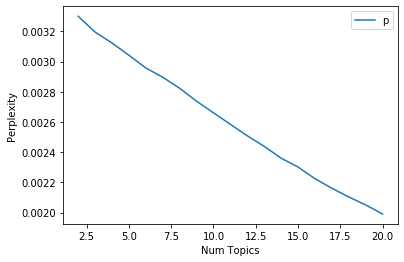

In [53]:
limit=20; start=2; step=1;
x = range(start, limit+1, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("perplexity_values"), loc='best')
plt.show()

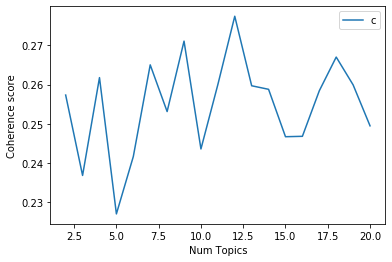

In [54]:
limit=20; start=2; step=1;
x = range(start, limit+1, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [55]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2573
Num Topics = 3  has Coherence Value of 0.2369
Num Topics = 4  has Coherence Value of 0.2618
Num Topics = 5  has Coherence Value of 0.2271
Num Topics = 6  has Coherence Value of 0.2417
Num Topics = 7  has Coherence Value of 0.265
Num Topics = 8  has Coherence Value of 0.2531
Num Topics = 9  has Coherence Value of 0.2711
Num Topics = 10  has Coherence Value of 0.2436
Num Topics = 11  has Coherence Value of 0.26
Num Topics = 12  has Coherence Value of 0.2774
Num Topics = 13  has Coherence Value of 0.2597
Num Topics = 14  has Coherence Value of 0.2588
Num Topics = 15  has Coherence Value of 0.2467
Num Topics = 16  has Coherence Value of 0.2468
Num Topics = 17  has Coherence Value of 0.2584
Num Topics = 18  has Coherence Value of 0.267
Num Topics = 19  has Coherence Value of 0.2599
Num Topics = 20  has Coherence Value of 0.2495


In [56]:
optimal_model = model_list[coherence_values.argmax()]

# 4. Encontraer el tópico dominante en cada documento

In [57]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, titles= titles, texts=data, categories=categories):
    # Init output
    sent_topics_df = pd.DataFrame()

    #Obtener tópico más probable de cada documento
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        #Obtener la id del tópico dominante, su peso  y las diez palabras más probables del tópico
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    #Añadir texto original del corpus
    title = pd.Series(titles)
    contents = pd.Series(texts)
    categories = pd.Series(categories) 
    sent_topics_df = pd.concat([sent_topics_df, title, contents, categories], axis=1)
    return sent_topics_df

In [58]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, 
                                                  titles=titles, texts=data, categories=categories)
df_dominant_topic = df_topic_sents_keywords.reset_index(drop=True)

In [59]:
df_dominant_topic.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,title,content,category
0,4.0,0.9905,"the, chile, personas, país, años, gobierno, po...",¿Lavar la ropa con luz?: invento de chilenos e...,Alumnos de Ingeniería de la Universidad Cató...,Nacional
1,1.0,0.5268,"personas, bío, años, ley, gobierno, empresa, n...","Alrededor de 40 mil hogares de Puente Alto, Pi...",Alrededor de 40 mil hogares de las comunas d...,Nacional
2,9.0,0.9894,"post, bío, this, instagram, the, shared, and, ...",Habla director de Compin Bío Bío que se autoap...,Quien fuera el director de la Compin Bío Bío...,Nacional
3,4.0,0.7576,"the, chile, personas, país, años, gobierno, po...",6 damnificados dejó incendio que destruyó una ...,Seis damnificados es el saldo de un incendio...,Nacional
4,7.0,0.9889,"chile, años, nacional, gobierno, bío, año, pos...",Con arresto domiciliario quedó menor detenido ...,Con arresto domiciliario total quedó el adol...,Nacional
5,0.0,0.4840,"años, bío, personas, gobierno, año, chile, ent...",Santiago buscará que el Instituto Nacional com...,"El alcalde de Santiago, Felipe Alessandri, d...",Nacional
6,6.0,0.5934,"trump, unidos, presidente, años, personas, paí...",Crisis interna del PS gatilla renuncia de 291 ...,291 militantes renunciaron al Partido Social...,Nacional
7,4.0,0.9880,"the, chile, personas, país, años, gobierno, po...",Organizaciones proponen innovador método para ...,Organizaciones sociales y vecinos de Santa I...,Nacional
8,7.0,0.9755,"chile, años, nacional, gobierno, bío, año, pos...",Objeto sospechoso obligó a cerrar estación de ...,La mañana de este lunes la presencia de un o...,Nacional
9,8.0,0.5139,"años, presidente, millones, chile, personas, c...",Peritajes al cuerpo de Cangri revelaron presen...,En febrero se produjeron las muertes de Seba...,Nacional


# 5. Encontrar el documento más representativo de cada tópico 

In [60]:
df_dominant_topic.sort_values(['Dominant_Topic', 'Perc_Contribution'], ascending = [True, False]).groupby('Dominant_Topic').first()

,Perc_Contribution,Topic_Keywords,title,content,category
Dominant_Topic,,,,,
0.0,0.9948,"años, bío, personas, gobierno, año, chile, ent...",Exesposa de mano derecha de obispo Durán y luj...,"Érika Bugueño , exesposa del mano derecha de...",Opinion
1.0,0.9949,"personas, bío, años, ley, gobierno, empresa, n...",Tras tragedias de 737 MAX: Boeing reportó el p...,Boeing presentó esta semana el peor resultad...,Economia
2.0,0.9956,"años, bío, personas, año, presidente, chile, c...",Corea del Norte dispara dos misiles de corto a...,Corea del Norte efectuó el jueves el lanzami...,Internacional
3.0,0.9958,"país, años, post, millones, chile, the, año, c...",¿Por qué bostezamos? las variadas hipótesis qu...,Las acciones más comunes que observamos en u...,Sociedad
4.0,0.9987,"the, chile, personas, país, años, gobierno, po...",Decreto Nº 56 del Minvu induce a la colusión p...,A propósito de reglamentar un vocablo sobre ...,Opinion
5.0,0.9960,"años, gobierno, caso, ley, bío, país, chile, m...",El polémico príncipe de Arabia Saudita llega a...,Human Rigths Watch (HRW) pidió al fiscal Ram...,Opinion
6.0,0.9958,"trump, unidos, presidente, años, personas, paí...",Los temas raciales se toman el inicio de la ca...,Cuando Barack Obama fue elegido en 2008 prim...,Internacional
7.0,0.9987,"chile, años, nacional, gobierno, bío, año, pos...",Caval: el Banco de Chile no debió prestarle plata,"Todo un “mito” fue el caso Caval, eso es lo ...",Opinion
8.0,0.9961,"años, presidente, millones, chile, personas, c...",China promete represalias tras amenazas de Tru...,China respondió con celeridad a Donald Trump...,Internacional


# 6. Número de documentos asociados a cada Tópico

Para cada tópico se cuenta los documentos donde este es dominante.

In [61]:
df_dominant_topic.groupby('Dominant_Topic').size().reset_index(name='count')

,Dominant_Topic,count
0,0.0,128
1,1.0,70
2,2.0,126
3,3.0,59
4,4.0,44
5,5.0,84
6,6.0,72
7,7.0,120
8,8.0,98
9,9.0,54
